<a href="https://colab.research.google.com/github/OVP2023/NN/blob/main/%D0%9D%D0%9D_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%B8_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%BB%D0%BE%D0%B8_%D0%BE%D0%B1%D0%B5%D1%80%D1%82%D0%BA%D0%B0_%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%81__%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BE%D0%B2_%D0%B22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.18.0


In [21]:
PLATE_NUM_LENGTH = 8

TEST_DATA_PATH = '/content/drive/MyDrive/Datasets/CV/plate/test'
TRAIN_DATA_PATH = '/content/drive/MyDrive/Datasets/CV/plate/train'

IMG_WIDTH = 128
IMG_HEIGHT = 64

POOL_NUM = 2
DOWNSAMPLE = POOL_NUM ** 2

In [22]:
#Загружаем алфавит
import os
import json
from collections import Counter
from glob import glob


def load_char_counts(path):
    """Загружаем словарь символов на основе данных разметки"""
    counts = Counter()
    for filename in glob(os.path.join(path, 'ann', '*.json')):
        with open(filename, 'r') as src:
            annotation = json.load(src)
        label = annotation['description']
        assert len(label) == PLATE_NUM_LENGTH
        counts.update(label)
    return counts

LETTERS = sorted(load_char_counts(TRAIN_DATA_PATH).keys())
print('Letters:', ' '.join(LETTERS))

Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


In [23]:
#Утилиты подготовки входных данных

import random
import functools

def indices_to_text(indicies, letters):
    """Возвращает текст для заданных индексов"""
    return ''.join(map(letters.__getitem__, indicies))

def text_to_indices(text, letters):
    """Конвертирует текст в список индексов"""
    return list(map(letters.index, text))

class DataGenerator:
    """Загрузка и подготвка данных для обучения/тестирования"""
    def __init__(self,
                 path,
                 img_width,
                 img_height,
                 batch_size,
                 letters,
                 max_label_len):

        self._img_height = img_height
        self._img_width = img_width
        self._batch_size = batch_size
        self._letters = letters
        self._max_label_len = max_label_len

        self._files = []
        for img_path in glob(os.path.join(path, 'img', '*.png')):
            basename, _ = os.path.splitext(os.path.basename(img_path))
            annotation_path = os.path.join(path, 'ann', '%s.json' % basename)
            with open(annotation_path, 'r') as src:
                annotation = json.load(src)
                self._files.append((img_path, annotation['description']))

    @property
    def steps_per_epoch(self):
        return len(self._files) // self._batch_size

    @functools.lru_cache(maxsize=1024)
    def _load_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self._img_width, self._img_height))
        img = np.float32(img) / 255.
        return img.reshape((self._img_height, self._img_width, 1))

    def __call__(self):
        while True:
            assert self.steps_per_epoch > 0

            batch_img = np.zeros(
                [self._batch_size,
                 self._img_height, self._img_width, 1], np.float32)

            random.shuffle(self._files)
            for i in range(0, len(self._files), self._batch_size):
                k = i + self._batch_size
                if k > len(self._files):
                    break

                batch_labels = np.zeros([self._batch_size,
                                         self._max_label_len], np.int32)

                batch_labels_length = np.zeros([self._batch_size, 1])

                for j, (img_path, label) in enumerate(self._files[i:k]):
                    batch_img[j] = self._load_img(img_path)
                    batch_labels[j] = text_to_indices(label, self._letters)
                    batch_labels_length[j] = len(label)

                outputs = {
                    'labels': batch_labels,
                    'labels_length': batch_labels_length
                }

                yield batch_img, outputs



Text generator output (data which will be fed into the neutral network):
1) input (image) 64x128


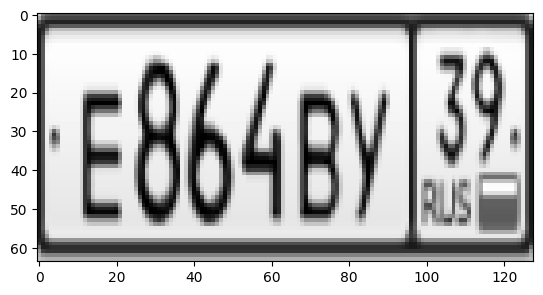

2) labels (plate number): E864BY39 is encoded as [13  8  6  4 11 21  3  9]
3) label_length (length of plate number): 8


<ipython-input-24-5475fe06d8ca>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('3) label_length (length of plate number): %d' % label_length)


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

data = DataGenerator(TRAIN_DATA_PATH,
                     batch_size=1,
                     img_width=128,
                     img_height=64,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)

x, y_true = next(data())
label_indices = y_true['labels'][0]
label = indices_to_text(label_indices, LETTERS)
label_length = y_true['labels_length'][0]

print('Text generator output (data which will be fed into the neutral network):')
print('1) input (image) %dx%d' % x[0].shape[:2])
plt.imshow(np.squeeze(x[0]), cmap='gray')
plt.show()

print('2) labels (plate number): %s is encoded as %s' % (label, label_indices))
print('3) label_length (length of plate number): %d' % label_length)

In [124]:
#Архитектура сети и функция потерь

from itertools import groupby
from tensorflow.keras import backend as K

class PlateOCR(tf.keras.Model):

    def __init__(self, input_shape,
                 num_classes, name='plate_ocr'):
        super(PlateOCR, self).__init__(name=name)

        img_height, img_width, img_channels = input_shape

        self._permute = tf.keras.layers.Permute(dims=(2, 1, 3),
                                                input_shape=input_shape,
                                                name='permute')

        self._conv1 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv_1')
        self._pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_1')

        self._conv2 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv_2')
        self._pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_2')

        self._rnn_input_length = img_width
        self._rnn_input_length //= self._pool1.pool_size[0]
        self._rnn_input_length //= self._pool2.pool_size[0]

        self._rnn_input_features = img_height
        self._rnn_input_features //= self._pool1.pool_size[1]
        self._rnn_input_features //= self._pool2.pool_size[1]
        self._rnn_input_features *= self._conv2.filters

        self._reshape = tf.keras.layers.Reshape(
            target_shape=(self._rnn_input_length,
                          self._rnn_input_features),
            name='reshape')

        self._dense = tf.keras.layers.Dense(32,
                                            activation='relu',
                                            name='dense_1')

        self._gru_1_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_1_fw')
        self._gru_1_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_1_bw')

        self._gru_2_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_2_fw')
        self._gru_2_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_2_bw')

        self._output = tf.keras.layers.Dense(num_classes + 1,
                                             activation='softmax',
                                             name='output')

        self.build(input_shape=(None, img_height, img_width, img_channels))

    def call(self, x):
        x = self._conv1(self._permute(x))
        x = self._pool1(x)

        x = self._conv2(x)
        x = self._pool2(x)

        x = self._dense(self._reshape(x))

        x = tf.keras.layers.add([self._gru_1_fw(x),
                                 self._gru_1_bw(x)])

        x = tf.keras.layers.add([self._gru_2_fw(x),
                                 self._gru_2_bw(x)])

        return self._output(x)

    def train_step(self, data):
        x, y_true = data

        labels = y_true['labels']
        labels_length = y_true['labels_length']

        input_length = self._rnn_input_length * tf.ones_like(labels_length)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = K.ctc_batch_cost(labels,
                                    y_pred,
                                    input_length,
                                    labels_length)

        gradients = tape.gradient(
            loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))

        return {'loss': loss}

    def decode(self, y_pred, letters):
        result = []
        for prediction in y_pred:
            indices = [i for i, _ in groupby(np.argmax(prediction, -1))]
            indices = [i for i in indices if i < len(letters)]
            result.append(indices_to_text(indices, letters))
        return result


In [125]:
#Обучение модели

model = PlateOCR(num_classes=len(LETTERS),
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/permute.py:36: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'plate_ocr', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "plate_ocr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ permute (Permute)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1_fw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1_bw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2_fw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2_bw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [126]:
EPOCHS = 200  #в идеале 200
BATCH_SIZE = 4

data = DataGenerator(TRAIN_DATA_PATH,
                     img_width=IMG_WIDTH,
                     img_height=IMG_HEIGHT,
                     batch_size=BATCH_SIZE,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)


In [127]:
model.compile(optimizer='adam')   #tf.keras.optimizers.Adam(lr=3e-4)

In [130]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/plate-ocr.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

In [131]:
model.fit(data(),
          epochs=EPOCHS,
          steps_per_epoch=data.steps_per_epoch,
          callbacks=[checkpoint])

Epoch 1/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 20.1787

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.674637]
 [23.802977]
 [24.372835]
 [17.095201]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 20.8435

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.176157]
 [21.91574 ]
 [20.0923  ]
 [23.57546 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 19.7751
Epoch 2/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 16.3173

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.5759735]
 [16.259302 ]
 [14.520359 ]
 [13.058583 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 13.5990

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.356824 ]
 [10.4957285]
 [ 5.6413655]
 [ 6.5964518]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 11.7189
Epoch 3/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 25.9165

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.218771]
 [17.945307]
 [32.78848 ]
 [26.150497]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 24.5346

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.87989 ]
 [21.43141 ]
 [22.04323 ]
 [16.220896]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 21.8088
Epoch 4/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 22.3751

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.877861]
 [18.97876 ]
 [19.264511]
 [24.454172]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 20.0983

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.57447 ]
 [25.027903]
 [18.494265]
 [20.80002 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 19.4318
Epoch 5/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20.9505

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.415962]
 [20.370289]
 [17.839607]
 [22.445202]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 20.0469

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.423712]
 [26.742998]
 [20.008125]
 [18.809896]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 20.0915

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.076576]
 [16.963589]
 [16.93746 ]
 [15.961078]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 19.0459
Epoch 6/200
 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.8976

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.461077]
 [20.332626]
 [20.156757]
 [22.745804]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 20.0269

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.673897]
 [16.904016]
 [25.655523]
 [19.596317]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 18.9989
Epoch 7/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19.1331

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.023195]
 [19.632711]
 [19.918808]
 [20.384815]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 20.0348

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.30024]
 [19.56318]
 [18.03233]
 [22.49891]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.7399
Epoch 8/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 15.6278

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.043369]
 [15.449944]
 [15.290002]
 [12.043083]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 13.7849

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.358616]
 [ 9.821311]
 [11.421717]
 [12.025057]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 11.6447
Epoch 9/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 24.1334

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.944986]
 [35.21227 ]
 [25.073418]
 [26.902845]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 23.1101

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.271133]
 [17.577213]
 [25.291801]
 [24.203098]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 20.7897
Epoch 10/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 22.0243

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.715397]
 [24.043863]
 [23.078758]
 [19.305218]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 20.3485

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.384405]
 [22.941586]
 [19.771742]
 [22.903492]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 20.2677

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.284051 ]
 [13.739968 ]
 [13.6999035]
 [14.671122 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 19.1291
Epoch 11/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.3639

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.002357]
 [11.266109]
 [13.423674]
 [13.586521]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 18.4385

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.67045 ]
 [21.609875]
 [23.270145]
 [18.23029 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 17.3032
Epoch 12/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 21.0516

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.06806 ]
 [17.051079]
 [21.055632]
 [19.74028 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 20.8654

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.521568]
 [19.792847]
 [23.181402]
 [20.478506]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 19.4609
Epoch 13/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 13.2646

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.568943 ]
 [12.831476 ]
 [12.0082855]
 [14.555691 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 12.7051

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.753718 ]
 [ 7.3543186]
 [10.277118 ]
 [11.001472 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 11.1138
Epoch 14/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.9868

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.195648]
 [18.3533  ]
 [17.4763  ]
 [22.78369 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.5079

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.715595]
 [18.406456]
 [20.26973 ]
 [21.995302]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 18.1298
Epoch 15/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.9812

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.75604 ]
 [22.714266]
 [23.450495]
 [20.073896]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 20.0808

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.348736]
 [22.320671]
 [20.884726]
 [16.045147]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 19.6679

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.161733]
 [ 8.561579]
 [11.071763]
 [ 9.379645]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 18.3726
Epoch 16/200
 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.1277

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.692135]
 [10.572755]
 [11.665179]
 [11.087516]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.1725

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.943098]
 [20.805542]
 [17.80885 ]
 [18.289299]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 18.1758
Epoch 17/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.8918

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.178842]
 [11.736543]
 [10.107917]
 [11.149993]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.7249

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.498898]
 [ 9.959175]
 [ 8.016252]
 [10.480748]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.7720 
Epoch 18/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 22.9562

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.304668]
 [24.859455]
 [20.82406 ]
 [20.871784]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 21.8474

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.570213]
 [29.798988]
 [15.612847]
 [20.317177]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 20.3564
Epoch 19/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.1341

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.161978]
 [ 9.045583]
 [ 8.134776]
 [ 6.594415]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.0058

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.14323  ]
 [8.0707245]
 [8.968616 ]
 [8.666173 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.9179
Epoch 20/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.9998

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[26.008806]
 [23.699362]
 [23.427675]
 [28.684238]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 19.6727

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.814627]
 [24.32006 ]
 [22.166304]
 [22.099764]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 21.6078

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 6.934974]
 [ 6.028472]
 [11.694271]
 [ 8.409326]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 20.1034
Epoch 21/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.5156

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.3405204]
 [6.1457653]
 [7.067491 ]
 [7.987079 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.2560

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.3470664]
 [6.7988415]
 [5.0570145]
 [5.4933906]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.7147
Epoch 22/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 25.0552

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.03948 ]
 [22.2387  ]
 [22.019417]
 [31.162426]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 23.8420

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.078285]
 [21.818382]
 [21.024065]
 [19.29766 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 21.6098
Epoch 23/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 15.7148

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.425266]
 [21.143911]
 [24.232887]
 [25.757927]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 18.6849

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.090416]
 [25.613165]
 [25.628817]
 [18.775732]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 17.8834
Epoch 24/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.1399

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.434504]
 [12.1451  ]
 [11.22028 ]
 [12.107247]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.0109

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.4243374]
 [6.3305655]
 [6.3452816]
 [8.65626  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.3056
Epoch 25/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 24.1709

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[29.732822]
 [24.367504]
 [22.120169]
 [18.868103]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - loss: 24.2771

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.310026 ]
 [ 6.2551527]
 [ 6.9929786]
 [ 6.9388924]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 22.5413

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.731425]
 [ 8.815428]
 [ 8.722155]
 [13.386674]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 20.9350
Epoch 26/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 18.6073

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.836952]
 [25.437458]
 [24.322979]
 [21.482462]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 19.1146

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.548393]
 [21.012299]
 [24.456438]
 [20.307775]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 18.2439
Epoch 27/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.7263

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.958885]
 [21.396797]
 [23.847477]
 [20.311068]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.6179

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.4059  ]
 [20.97674 ]
 [29.108212]
 [19.463598]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 18.1144
Epoch 28/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 15.8837

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.61533 ]
 [19.011627]
 [20.16841 ]
 [23.418905]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 19.2259

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.336958]
 [22.15712 ]
 [20.075756]
 [17.349373]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 17.9441
Epoch 29/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.4675

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.229588]
 [10.37157 ]
 [ 9.04415 ]
 [ 9.567297]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.9192

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 7.3401337]
 [ 8.89982  ]
 [11.215757 ]
 [ 8.4301   ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.2677
Epoch 30/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 23.0041

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.87269 ]
 [20.51304 ]
 [20.487688]
 [25.59749 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 23.1232

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.137068]
 [18.65873 ]
 [23.50885 ]
 [24.184326]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 21.0673

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.93637  ]
 [8.7061825]
 [9.620528 ]
 [8.269453 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 19.6216
Epoch 31/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 21.6751

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.536917]
 [20.477266]
 [21.237198]
 [20.062595]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 20.5334

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.094347]
 [19.12856 ]
 [19.884289]
 [20.580889]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 19.2796
Epoch 32/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20.2506

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.304777]
 [24.035248]
 [20.248133]
 [19.654203]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 20.1866

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.17224 ]
 [23.46738 ]
 [21.256426]
 [20.756777]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 19.0620
Epoch 33/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 19.3342

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.886002]
 [19.688118]
 [21.2265  ]
 [17.914476]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 19.5048

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.960125]
 [20.79519 ]
 [20.528305]
 [19.604305]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 18.2298
Epoch 34/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.0607

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.228941]
 [20.942713]
 [22.328674]
 [18.503658]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 19.1990

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.065247]
 [20.03745 ]
 [17.802574]
 [22.613476]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 18.2943
Epoch 35/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.2637

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.995895]
 [20.247917]
 [20.854027]
 [17.815744]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 18.4639

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.194809]
 [19.032045]
 [19.432064]
 [19.826841]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 18.9515

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.885237]
 [14.075526]
 [11.697893]
 [15.965441]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 17.9082
Epoch 36/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.8576

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.869703]
 [23.824303]
 [20.478828]
 [25.976753]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 18.3170

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.69824 ]
 [10.227547]
 [11.613152]
 [10.7342  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 17.0147
Epoch 37/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.3137

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.776024]
 [13.300522]
 [11.252853]
 [ 9.262542]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18.3265

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.596712]
 [19.87669 ]
 [20.782774]
 [18.206455]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 17.6233
Epoch 38/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 11.3373

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.096134]
 [ 9.706948]
 [12.57671 ]
 [11.408949]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 10.6837

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.951845]
 [8.253133]
 [8.521746]
 [9.469909]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.5549 
Epoch 39/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.2044

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.764172]
 [28.719181]
 [17.96357 ]
 [28.645071]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 19.2998

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.355145 ]
 [ 7.1622033]
 [ 5.572867 ]
 [ 7.0197287]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 19.0208
Epoch 40/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.0096

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.600136]
 [24.219604]
 [21.924797]
 [23.728275]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 21.5112

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.50208 ]
 [22.022726]
 [23.381365]
 [28.111034]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 20.4082

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.316462]
 [11.79126 ]
 [13.593669]
 [13.984897]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 19.1845
Epoch 41/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.3091

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.12316 ]
 [19.648603]
 [18.104542]
 [20.678566]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 20.2547

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.781052]
 [18.77805 ]
 [19.566595]
 [17.726593]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 19.0109
Epoch 42/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.1049

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.127795]
 [14.40326 ]
 [14.708742]
 [14.544953]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.1815

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.300039 ]
 [13.3731575]
 [12.296232 ]
 [15.281215 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 16.9807
Epoch 43/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 19.7032

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.915554]
 [17.902483]
 [23.769596]
 [20.12304 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 19.2814

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.339433 ]
 [12.5253105]
 [11.68161  ]
 [11.283106 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 18.0243
Epoch 44/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18.5021

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.201023]
 [14.601187]
 [19.560715]
 [20.248621]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 19.5258

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.223461]
 [20.162138]
 [16.993208]
 [18.680923]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 18.5257
Epoch 45/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 14.8786

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.991163]
 [20.917332]
 [19.105036]
 [25.151915]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.2384

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.27716 ]
 [20.584145]
 [18.658058]
 [17.87232 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.1900

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.835254]
 [14.396775]
 [13.837294]
 [18.597008]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 18.1916
Epoch 46/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13.8469

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.608765]
 [11.942061]
 [12.597691]
 [12.405473]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 12.3642

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.444041 ]
 [11.387508 ]
 [ 9.0953865]
 [ 9.835846 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 11.5507
Epoch 47/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.6413

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.166006]
 [23.684357]
 [25.916557]
 [26.919151]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 19.4136

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.460665]
 [19.723434]
 [19.190727]
 [21.614685]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 17.2792
Epoch 48/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 21.3443

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.307165]
 [18.406519]
 [19.42267 ]
 [22.957375]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21.1139

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.2451515]
 [13.929514 ]
 [ 7.526932 ]
 [11.754146 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 19.2767
Epoch 49/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 18.1944

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.16331 ]
 [21.351954]
 [23.752768]
 [20.633947]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.0269

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.26325 ]
 [19.017593]
 [19.038103]
 [18.237417]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 17.4081
Epoch 50/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.3555

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.755093]
 [11.819121]
 [10.095089]
 [12.327522]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 10.3397

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.283567]
 [ 9.066809]
 [10.916815]
 [ 9.671785]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.6370

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.680388]
 [9.163784]
 [8.527652]
 [6.771395]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 9.1484
Epoch 51/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.3982

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.902662]
 [26.226837]
 [21.751488]
 [21.61453 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 21.2035

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.022827]
 [21.216755]
 [20.55405 ]
 [21.602568]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 19.8909
Epoch 52/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4318

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.607878 ]
 [9.868242 ]
 [8.604895 ]
 [9.2373905]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 7.6442

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[3.954924 ]
 [5.6010194]
 [6.9211035]
 [7.7219663]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 7.0032
Epoch 53/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 23.0500

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.930313]
 [21.754414]
 [23.91887 ]
 [18.299587]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 20.0952

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[30.80821 ]
 [26.261532]
 [23.65525 ]
 [21.205647]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 19.0673
Epoch 54/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.7518

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.216286]
 [26.318129]
 [24.90834 ]
 [17.654352]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 20.4154

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.113316]
 [10.327835]
 [11.399874]
 [12.485088]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 18.9499
Epoch 55/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.2458

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.485771]
 [14.322014]
 [22.933882]
 [19.79827 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 17.9323

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.370441]
 [11.337579]
 [14.049335]
 [12.633975]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 17.1222

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.518825]
 [11.24153 ]
 [10.143535]
 [10.08609 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 16.0789
Epoch 56/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 15.2176

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.10439  ]
 [8.098772 ]
 [9.414371 ]
 [7.4756317]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 16.6125

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.371342]
 [22.350441]
 [19.42115 ]
 [21.100647]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 15.6001
Epoch 57/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.1160

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.474333]
 [20.226013]
 [17.77518 ]
 [19.628525]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.1095

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.854193 ]
 [15.7415495]
 [20.45677  ]
 [21.613985 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 18.2491
Epoch 58/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.4935

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.298243]
 [21.013994]
 [20.634502]
 [21.218376]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 18.5625

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.195429]
 [14.442737]
 [10.069537]
 [ 9.650296]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.7543
Epoch 59/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.2097

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.95069 ]
 [20.270224]
 [22.628132]
 [18.900986]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.1446

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.348291]
 [18.01722 ]
 [20.585865]
 [26.018246]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.4627
Epoch 60/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 12.6992

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.986782]
 [19.485245]
 [20.752487]
 [18.619478]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 18.1673

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.124596]
 [18.300587]
 [19.64394 ]
 [25.438232]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 17.6596

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.242846]
 [12.534792]
 [11.93191 ]
 [13.300843]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 16.6893
Epoch 61/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17.4754

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.766333]
 [23.270699]
 [19.367975]
 [26.205141]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 19.4328

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.974302]
 [16.840609]
 [18.387154]
 [17.621548]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 18.2649
Epoch 62/200
 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9099

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.982417]
 [11.551586]
 [11.318101]
 [10.476378]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 10.3314

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.8085985]
 [8.359979 ]
 [7.4197574]
 [8.359675 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 9.4912 
Epoch 63/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.5019

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.143623]
 [18.217745]
 [19.924566]
 [21.18479 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 22.5121

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.933989]
 [20.484552]
 [22.16997 ]
 [22.0174  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 20.6884
Epoch 64/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.2734

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.9929695]
 [6.7090454]
 [8.302907 ]
 [8.599858 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.2668

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.076275]
 [7.934534]
 [8.96435 ]
 [8.441364]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.5557
Epoch 65/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 22.9071

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.284134]
 [23.960464]
 [24.27924 ]
 [18.30888 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 20.6511

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.116745]
 [22.273678]
 [19.418701]
 [21.771395]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 20.8520

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.7956934]
 [6.6297917]
 [7.080007 ]
 [6.6434994]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 19.3230
Epoch 66/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13.6289

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.117014]
 [22.44619 ]
 [21.930048]
 [22.616354]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 14.6638

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.453032]
 [18.25099 ]
 [24.553144]
 [21.430067]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 14.0007
Epoch 67/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.0329

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.5637436]
 [5.1255302]
 [7.31551  ]
 [8.309153 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.5034

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.0721536]
 [4.615784 ]
 [4.18349  ]
 [5.18222  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.9817
Epoch 68/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.6864

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.89519 ]
 [29.793306]
 [31.606577]
 [31.019012]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.9347

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[3.209165 ]
 [4.631224 ]
 [7.3475657]
 [5.910257 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 19.0271
Epoch 69/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 22.2398

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.903303]
 [22.78587 ]
 [20.184996]
 [22.68522 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.2262

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[4.7580495]
 [7.010367 ]
 [4.2570333]
 [5.6133275]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 15.6919
Epoch 70/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20.7127

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.561295]
 [22.951462]
 [24.192478]
 [21.92447 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 20.7772

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.220793]
 [23.782093]
 [20.154074]
 [26.012522]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 20.0198

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.372337 ]
 [11.215363 ]
 [12.393048 ]
 [11.3395405]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 18.8041
Epoch 71/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.9659 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 5.726432 ]
 [ 5.7663193]
 [ 5.0311966]
 [11.225737 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 8.7618

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.179028]
 [6.500973]
 [5.229623]
 [5.943673]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 8.0862
Epoch 72/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20.3462

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.540869]
 [26.418926]
 [29.327211]
 [26.171227]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.1224

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.278645]
 [23.152813]
 [19.27121 ]
 [21.513014]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 19.8104
Epoch 73/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.5179

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.126545]
 [27.424543]
 [22.218538]
 [20.87231 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.7263

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.968916]
 [20.337826]
 [16.039307]
 [21.167093]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 17.7789
Epoch 74/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18.7354

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.294395]
 [20.185368]
 [23.321358]
 [21.652876]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 17.8611

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.864378]
 [18.262932]
 [22.679136]
 [10.081764]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 17.4403
Epoch 75/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.2090

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.348932]
 [19.95907 ]
 [16.352118]
 [19.32276 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 18.6258

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.893883]
 [22.312458]
 [21.57541 ]
 [19.225273]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.7096

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.21681 ]
 [12.352994]
 [11.732691]
 [13.597257]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 18.5599
Epoch 76/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 12.0898

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.507071]
 [11.481735]
 [ 7.869124]
 [ 9.904911]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 10.2994

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 6.788035]
 [ 8.24941 ]
 [ 8.791275]
 [10.351794]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.4223 
Epoch 77/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.6778

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.866741]
 [26.700663]
 [17.541325]
 [21.566381]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 22.6372

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.6865187]
 [8.124745 ]
 [7.781336 ]
 [8.233028 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 19.9642
Epoch 78/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15.5638

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.535581]
 [23.025093]
 [25.237007]
 [22.008442]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 17.9082

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[9.683719 ]
 [9.346012 ]
 [6.0622444]
 [7.8701887]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.2270
Epoch 79/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10.0067

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.0060062]
 [9.350819 ]
 [8.808182 ]
 [8.1639805]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 8.6507

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.762603 ]
 [8.655345 ]
 [7.536088 ]
 [6.9223094]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.5612
Epoch 80/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 23.3183

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.364101]
 [15.5767  ]
 [30.089851]
 [20.36021 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 20.7655

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.832954]
 [20.101904]
 [22.579626]
 [22.218195]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 21.2276

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.060544 ]
 [7.0497694]
 [7.4124823]
 [6.309354 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 19.7074
Epoch 81/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 17.7979

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.936132]
 [17.848536]
 [23.620476]
 [20.24476 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.7234

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.641777]
 [25.719528]
 [21.8526  ]
 [21.128035]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.5441
Epoch 82/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 15.4934

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.701513]
 [23.228443]
 [23.200764]
 [18.979736]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.3951

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.416733]
 [22.681461]
 [24.468885]
 [18.188055]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.4043
Epoch 83/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.1795

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.010475]
 [20.270306]
 [17.592031]
 [19.199535]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.0435

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.62691 ]
 [19.62005 ]
 [20.886848]
 [20.912968]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.9615
Epoch 84/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13.3175

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.036665]
 [20.343021]
 [24.191696]
 [22.040956]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - loss: 16.5536

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.312748]
 [21.259155]
 [17.320492]
 [21.628199]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 17.2414
Epoch 85/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 20.2593

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.274353]
 [22.281996]
 [22.958881]
 [20.92564 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 20.1310

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.473446]
 [20.401165]
 [19.163525]
 [18.18792 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 20.2776

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.348801]
 [11.844372]
 [10.425015]
 [14.024271]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 19.0135
Epoch 86/200
 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.7507

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.108149]
 [19.074585]
 [18.620739]
 [18.862848]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 18.9718

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.08955 ]
 [20.537262]
 [19.27221 ]
 [21.221724]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 18.1227
Epoch 87/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.7117

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.719894]
 [11.289633]
 [12.663977]
 [13.706902]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.0943

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.671505]
 [20.95276 ]
 [17.899376]
 [19.433754]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.6627
Epoch 88/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 11.4138

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.585874]
 [10.089447]
 [10.261517]
 [11.615438]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.4489

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.221308]
 [ 8.784485]
 [ 7.16063 ]
 [10.100292]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.3703
Epoch 89/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.1946

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.08824 ]
 [22.775665]
 [20.209038]
 [21.145622]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 21.0796

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.4406605]
 [6.527727 ]
 [7.325041 ]
 [5.790809 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 19.2358
Epoch 90/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 23.4412

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.820402]
 [22.951447]
 [22.552738]
 [19.826338]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 16.4923

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.646162]
 [19.540878]
 [20.776264]
 [20.327045]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 18.2459

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.67976 ]
 [ 8.006413]
 [ 8.845295]
 [ 8.515879]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 17.0511
Epoch 91/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.1948

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.402592]
 [26.463524]
 [19.83852 ]
 [23.886875]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 19.8243

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.69607 ]
 [25.011917]
 [20.239511]
 [20.423542]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.5169
Epoch 92/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 11.7270

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.091398]
 [10.244251]
 [ 8.973438]
 [10.175558]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.9603 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[9.164784]
 [8.541991]
 [8.0371  ]
 [8.345476]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.9386
Epoch 93/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.1764

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.823864 ]
 [14.9524355]
 [24.099167 ]
 [27.20368  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 19.1899

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.714201]
 [20.844854]
 [24.045204]
 [22.176203]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 16.2974
Epoch 94/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4208

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.340204 ]
 [5.211068 ]
 [5.9061728]
 [6.531994 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.7962

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.6843524]
 [4.776932 ]
 [7.216676 ]
 [6.2078466]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.2915
Epoch 95/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 29.3586

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[29.796453]
 [26.413689]
 [18.175907]
 [21.861542]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 22.2988

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.598768]
 [23.518845]
 [25.76142 ]
 [20.905825]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 23.0909

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.8904295]
 [ 9.932171 ]
 [10.457788 ]
 [ 9.75494  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 21.4035
Epoch 96/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 20.2735

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.284973]
 [22.729044]
 [20.715927]
 [20.344671]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 20.4784

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.866161]
 [21.11294 ]
 [19.013016]
 [21.364431]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 19.4122
Epoch 97/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.6748

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.18332 ]
 [22.01723 ]
 [19.526718]
 [20.5676  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.6306

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.185858]
 [23.782303]
 [19.567623]
 [20.018042]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 18.7457
Epoch 98/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.6952

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.089247]
 [17.235777]
 [20.37118 ]
 [18.10659 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 19.3597

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.297169]
 [20.467287]
 [17.443462]
 [18.711157]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 18.3318
Epoch 99/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 14.0590

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.3852825]
 [11.723463 ]
 [12.174128 ]
 [16.170786 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 11.6353

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.977349]
 [8.484295]
 [6.240723]
 [7.762709]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.1676
Epoch 100/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 23.1798

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[4.834899]
 [5.851477]
 [6.065089]
 [4.699281]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - loss: 14.3197

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[26.086246]
 [33.731068]
 [18.804352]
 [15.619965]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 19.6334

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.6998816]
 [9.156672 ]
 [7.464978 ]
 [8.000055 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 18.2775
Epoch 101/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.8016

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.0118046]
 [4.04207  ]
 [5.224142 ]
 [5.926775 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.1108

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.5320745]
 [4.8284802]
 [4.7891364]
 [5.655936 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.6174
Epoch 102/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.9229

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[4.3586245]
 [4.4730244]
 [4.2959547]
 [3.740949 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 22.0356

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.433994]
 [24.450361]
 [19.276281]
 [29.22592 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 20.4264
Epoch 103/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.6944

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.102871 ]
 [7.5998683]
 [7.98286  ]
 [8.181614 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.4756

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[4.9633083]
 [5.1994653]
 [3.9545636]
 [6.104109 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 6.3658
Epoch 104/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 24.6175

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.968775]
 [25.5784  ]
 [28.881899]
 [31.743017]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 24.8409

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[26.510414]
 [21.903246]
 [24.360073]
 [28.451431]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 21.4853
Epoch 105/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 20.5777

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.465277]
 [25.067152]
 [20.99984 ]
 [24.085375]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 19.6306

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.455444]
 [16.534002]
 [23.965445]
 [20.00283 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 19.2630

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.277697]
 [11.44894 ]
 [15.38783 ]
 [13.815156]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 18.1958
Epoch 106/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 19.9119

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.155409]
 [19.72154 ]
 [22.72159 ]
 [21.256042]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.1089

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.709017]
 [12.132548]
 [13.433926]
 [13.168644]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 17.4062
Epoch 107/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.7313

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.080025]
 [20.334148]
 [20.238777]
 [24.75508 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.2429

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.43929 ]
 [19.30811 ]
 [22.79212 ]
 [21.497465]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 19.8130
Epoch 108/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 15.9150

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.467743]
 [19.46086 ]
 [20.179705]
 [19.175041]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 16.8115

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.723465]
 [19.858261]
 [19.277378]
 [19.032429]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 15.4811
Epoch 109/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20.5506

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.564392]
 [22.244402]
 [20.250805]
 [20.519016]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 20.7654

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.678902]
 [19.483982]
 [28.801758]
 [19.405003]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 18.8176
Epoch 110/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18.5126

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.337015]
 [21.829287]
 [22.473618]
 [20.04975 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 19.4044

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.861235]
 [19.188637]
 [22.199675]
 [20.161068]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 19.2120

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.177057]
 [13.012042]
 [11.390779]
 [11.340505]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 18.1279
Epoch 111/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 11.5176

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.019145]
 [ 9.416519]
 [10.385969]
 [ 9.390757]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 9.9841 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.405816]
 [8.144805]
 [7.014348]
 [8.657753]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.1142
Epoch 112/200
 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.4288

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.20229 ]
 [17.686375]
 [22.539473]
 [26.976547]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 18.1058

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.378895]
 [28.246777]
 [29.281307]
 [21.909132]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 16.4824
Epoch 113/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.1434

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.737561 ]
 [5.1133184]
 [6.565329 ]
 [5.0351863]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.8573

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.116653 ]
 [6.1464114]
 [6.3045883]
 [4.402754 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 5.2856
Epoch 114/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26.0665

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.891546]
 [23.079777]
 [25.704132]
 [25.301632]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 22.3617

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.683243]
 [25.606287]
 [26.889229]
 [26.1975  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 20.4183
Epoch 115/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19.6197

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.167045 ]
 [7.038625 ]
 [6.2362137]
 [6.368579 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 19.2578

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.34588 ]
 [19.897736]
 [19.437857]
 [21.75517 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 19.3899

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.495618 ]
 [11.887782 ]
 [10.7031975]
 [11.190582 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 18.2479
Epoch 116/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.8129

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.6440244]
 [9.404993 ]
 [8.044514 ]
 [9.140944 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.5541

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.3478975]
 [7.9387913]
 [9.493315 ]
 [6.296335 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.8502
Epoch 117/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 23.2947

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.11624 ]
 [21.371021]
 [20.07544 ]
 [24.154482]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 20.2434

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[4.804725 ]
 [6.347661 ]
 [5.8336697]
 [6.4308686]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 17.7157
Epoch 118/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.3653

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.466519 ]
 [6.9684763]
 [7.4598083]
 [5.1400967]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.7327

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.062047 ]
 [4.9407644]
 [4.466428 ]
 [5.7988124]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 5.1878
Epoch 119/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.1628

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.0471  ]
 [21.738712]
 [25.95628 ]
 [30.405783]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 22.6195

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.69043 ]
 [19.490978]
 [21.992128]
 [28.065868]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 20.4836
Epoch 120/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 20.9676

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.309578]
 [22.625965]
 [31.345877]
 [25.233631]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 22.1307

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.058256]
 [19.575989]
 [21.319185]
 [17.164452]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 21.0230

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.494269]
 [16.78691 ]
 [17.415693]
 [17.24297 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 19.8937
Epoch 121/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.7093

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.531853]
 [22.855364]
 [20.859308]
 [20.414524]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.6613

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.73947 ]
 [22.125368]
 [17.95821 ]
 [19.516855]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 18.5183
Epoch 122/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.3263

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.933363 ]
 [13.8467045]
 [11.501788 ]
 [15.763721 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.7830

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.09731 ]
 [21.05066 ]
 [19.970352]
 [23.624672]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 17.9820
Epoch 123/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.4694

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.833378]
 [18.71291 ]
 [20.889273]
 [18.139473]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 18.6589

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.431713 ]
 [12.6138315]
 [12.044383 ]
 [ 8.939931 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 17.6764
Epoch 124/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.0029

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.093246]
 [21.024565]
 [26.331556]
 [19.765146]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 20.3876

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.567428]
 [10.900782]
 [12.58548 ]
 [12.030266]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.3554
Epoch 125/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12.7742

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.298512 ]
 [12.7691145]
 [12.782901 ]
 [12.715001 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 11.4109

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.0740504]
 [6.175151 ]
 [9.965372 ]
 [8.353746 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 9.6853 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.343608 ]
 [6.3268623]
 [7.9738884]
 [5.9321775]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.1537
Epoch 126/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.4778

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[29.351593]
 [20.888931]
 [16.852652]
 [30.821398]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 20.1957

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.13759 ]
 [24.104893]
 [23.711218]
 [27.22153 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 19.0927
Epoch 127/200
 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 18.8286

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.642406]
 [18.617836]
 [17.328585]
 [21.838612]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.1633

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.999878]
 [24.926182]
 [22.180777]
 [17.840612]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.1196
Epoch 128/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.4298

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.970922]
 [16.841402]
 [20.581074]
 [23.582144]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 18.7847

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.100742]
 [18.240265]
 [21.523499]
 [19.540558]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.9196
Epoch 129/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.3873

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.723862]
 [20.571558]
 [21.175407]
 [28.70224 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18.7574

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.530157]
 [22.29467 ]
 [22.416962]
 [20.645132]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.4300
Epoch 130/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4291

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.796528]
 [18.55103 ]
 [22.847282]
 [19.111237]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 19.2034

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.211104]
 [21.715069]
 [21.219015]
 [18.640316]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 18.9806

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.007774]
 [12.036968]
 [11.019408]
 [12.919792]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 17.8517
Epoch 131/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.5843

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 7.808214]
 [ 9.441974]
 [10.042293]
 [ 9.452128]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 9.5679

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.273937 ]
 [7.1360283]
 [7.3310356]
 [6.4495344]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 8.7667
Epoch 132/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 22.2742

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.259428]
 [22.6902  ]
 [26.64773 ]
 [22.282938]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.2628

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.099487]
 [26.188639]
 [30.045034]
 [18.291397]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 20.0845
Epoch 133/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.9733

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.3312807]
 [8.404568 ]
 [9.722365 ]
 [6.0407457]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.5169

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.995463 ]
 [6.7092285]
 [7.110592 ]
 [6.6410885]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.8812
Epoch 134/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 22.3496

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[5.872285 ]
 [4.0729113]
 [5.2747664]
 [5.204606 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 17.3815

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.231762]
 [26.053114]
 [20.30592 ]
 [26.511034]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 16.4224
Epoch 135/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 24.4200

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.489399]
 [21.643917]
 [18.078331]
 [23.187029]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 21.9704

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.344536]
 [21.063038]
 [20.784842]
 [19.220385]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 21.4844

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.383474]
 [10.694116]
 [15.226683]
 [14.366804]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 20.1271
Epoch 136/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.3999

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.01901 ]
 [18.146212]
 [19.57377 ]
 [19.53474 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.8266

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.602581]
 [13.220096]
 [16.342813]
 [15.696328]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 17.1495
Epoch 137/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.6785

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.871721]
 [19.983269]
 [18.886555]
 [17.529415]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 19.9565

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.307993]
 [22.55486 ]
 [20.591648]
 [20.839624]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 18.8128
Epoch 138/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 17.7206

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.263655]
 [16.115694]
 [20.04338 ]
 [19.657534]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 17.6905

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.288935]
 [21.345898]
 [17.349644]
 [20.685295]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 17.4122
Epoch 139/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 19.2764

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.986628]
 [20.938377]
 [19.970175]
 [17.778086]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 19.9080

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.700556]
 [19.144503]
 [23.012613]
 [19.777393]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 18.6002
Epoch 140/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 20.9002

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.590548]
 [17.842133]
 [22.018875]
 [18.95798 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 18.9532

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.298746]
 [16.710129]
 [17.121784]
 [20.45705 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 18.5433

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.945425]
 [12.474042]
 [12.920491]
 [13.023115]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 17.5467
Epoch 141/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 18.6638

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.402365]
 [20.473488]
 [22.12475 ]
 [21.486383]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 19.4655

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.504588]
 [20.025448]
 [19.861406]
 [15.665745]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.7027
Epoch 142/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.8556

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.647396]
 [21.062815]
 [18.567686]
 [21.88085 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 17.9048

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.027248]
 [19.760391]
 [22.134014]
 [22.691532]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 16.0288
Epoch 143/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.1320

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.312178]
 [16.356302]
 [22.860804]
 [23.181723]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 18.0875

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 8.803034]
 [ 8.627996]
 [11.010736]
 [ 7.071162]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 15.5709
Epoch 144/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.7495

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[6.143238 ]
 [9.382419 ]
 [8.667555 ]
 [6.6664567]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.6863

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.852511 ]
 [6.512022 ]
 [6.264512 ]
 [6.3972287]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.7596
Epoch 145/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.7168

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.691002]
 [18.15978 ]
 [25.62475 ]
 [20.292458]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 21.2683

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.351633]
 [29.8031  ]
 [17.664724]
 [22.62683 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 22.0843

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.549016 ]
 [8.217244 ]
 [8.239414 ]
 [5.6744933]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 20.4865
Epoch 146/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.6515

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.490349]
 [16.734884]
 [26.40204 ]
 [22.22433 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 19.6439

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.980787]
 [22.18296 ]
 [17.786268]
 [24.616327]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 18.4869
Epoch 147/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.1589

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.59997 ]
 [13.054939]
 [13.64708 ]
 [14.510845]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 18.1533

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.855923]
 [21.038904]
 [21.683292]
 [20.988504]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.1508
Epoch 148/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 20.3568

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.119043]
 [19.236715]
 [19.347477]
 [18.577984]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 17.4872

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.38182  ]
 [7.9298315]
 [7.0426264]
 [9.482409 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 16.4951
Epoch 149/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 20.9788

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.617393]
 [21.361668]
 [23.123573]
 [22.76326 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 20.7978

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.226667]
 [20.843178]
 [18.799967]
 [25.97862 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 18.1998
Epoch 150/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 10.9522

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.697157]
 [17.84687 ]
 [19.63983 ]
 [21.906656]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 17.0841

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.022745]
 [10.690987]
 [ 9.876395]
 [ 9.824966]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 18.3744

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.57351 ]
 [10.297757]
 [ 9.27882 ]
 [10.670381]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 17.3628
Epoch 151/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 19.4952

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.475584]
 [17.693834]
 [17.105743]
 [16.963995]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.0868

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.353216]
 [16.855698]
 [16.040016]
 [18.826826]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.1531
Epoch 152/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.0655

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.146742]
 [15.39862 ]
 [20.089779]
 [18.696747]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 18.2378

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.852461]
 [11.115805]
 [11.980079]
 [10.286083]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 17.2332
Epoch 153/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.6209

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.01387 ]
 [25.011803]
 [15.599633]
 [21.25093 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 16.6050

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.4961042]
 [9.440009 ]
 [9.826106 ]
 [8.54288  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 15.3471
Epoch 154/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.2715

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[28.344213]
 [25.117754]
 [14.335489]
 [27.104364]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.4031

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.443155]
 [19.968122]
 [19.717627]
 [24.901182]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 15.9733
Epoch 155/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19.9079

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.168793]
 [20.34027 ]
 [25.137466]
 [20.907272]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 18.4083

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.815916]
 [19.764357]
 [18.45244 ]
 [19.581415]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 17.9952

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 7.6635904]
 [ 8.699107 ]
 [ 6.776333 ]
 [12.066836 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 16.4177
Epoch 156/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15.3498

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.521652]
 [10.347967]
 [ 8.024238]
 [ 8.88836 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 17.9781

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.85216 ]
 [16.88969 ]
 [20.261057]
 [19.59636 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.3338
Epoch 157/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 20.2753

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.579538]
 [19.920801]
 [21.48833 ]
 [20.175179]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 20.1334

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.921047]
 [21.002672]
 [22.56938 ]
 [21.441074]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 18.5827
Epoch 158/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.8726

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.245876]
 [20.563725]
 [19.626183]
 [21.881273]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.4242

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.530876]
 [23.116892]
 [18.027145]
 [20.421305]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.4565
Epoch 159/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 17.9410

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[26.585152]
 [22.3779  ]
 [20.274105]
 [16.96461 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 19.4251

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.949518]
 [21.36992 ]
 [22.881199]
 [20.068241]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 18.6408
Epoch 160/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 19.6581

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.024353]
 [19.594912]
 [20.494343]
 [17.922657]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 19.0966

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.76115 ]
 [22.727737]
 [20.159046]
 [17.39697 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 18.7422

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.771296]
 [13.231631]
 [13.594417]
 [12.128857]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 17.5079
Epoch 161/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 17.8716

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.920776]
 [20.410969]
 [16.89589 ]
 [19.524689]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18.6781

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.239738]
 [19.248892]
 [24.89002 ]
 [18.725588]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.7043
Epoch 162/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.1778

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.858768]
 [21.913128]
 [18.045113]
 [22.344112]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 18.1758

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.774828]
 [18.937561]
 [20.043064]
 [19.876127]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.1753
Epoch 163/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.1784

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.484379]
 [18.072964]
 [18.187061]
 [17.868368]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 18.8611

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.474375]
 [20.240925]
 [19.783888]
 [18.96898 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 18.0587
Epoch 164/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17.5698

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.788904]
 [21.601301]
 [19.731524]
 [19.842255]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 19.4433

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[15.592727 ]
 [14.532255 ]
 [15.487083 ]
 [13.6024885]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.0110
Epoch 165/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20.0063

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.931547]
 [11.226589]
 [12.715024]
 [11.293698]]. Falling back to `save_best_only=False`.
  warnings.warn(


11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 18.4453

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.128394]
 [12.461018]
 [12.743399]
 [11.327204]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 17.2795

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.942626]
 [ 9.408626]
 [ 9.856861]
 [13.041494]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 16.2470
Epoch 166/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.2659

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.411957]
 [25.004604]
 [20.415663]
 [18.084757]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 17.2571

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.67423 ]
 [21.663044]
 [20.32243 ]
 [13.978622]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 16.7360
Epoch 167/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.3642

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.74411 ]
 [21.965147]
 [20.126455]
 [21.321676]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 19.2681

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.023693]
 [21.190224]
 [19.766207]
 [18.42442 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 18.3462
Epoch 168/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 19.3036

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.540668]
 [20.118156]
 [18.360453]
 [19.327747]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 18.8882

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.203278]
 [14.12259 ]
 [18.434618]
 [20.671759]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 17.6851
Epoch 169/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 19.9509

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.243355]
 [18.673805]
 [19.470833]
 [17.717707]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 19.7470

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.754602]
 [18.524826]
 [19.48974 ]
 [18.467083]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 18.3244
Epoch 170/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.3168

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.809938]
 [24.950125]
 [19.359482]
 [21.460245]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 19.8747

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.530617]
 [19.504261]
 [18.18326 ]
 [19.525103]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 19.0071

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.333815]
 [15.424748]
 [12.933707]
 [12.979637]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 17.9594
Epoch 171/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.0576

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.420639]
 [16.922321]
 [21.284435]
 [19.103994]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.5483

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.985962]
 [21.499298]
 [16.22891 ]
 [22.18309 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.6325
Epoch 172/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.2925

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.58413 ]
 [14.763137]
 [12.723492]
 [13.450762]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 18.5399

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.428392]
 [11.052802]
 [13.423048]
 [12.768619]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.4077
Epoch 173/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.7807

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.437118]
 [11.41658 ]
 [13.526241]
 [12.41375 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 18.9718

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.933601]
 [19.573986]
 [25.670197]
 [19.548141]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 17.4545
Epoch 174/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19.2407

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.764786]
 [16.884888]
 [19.104404]
 [19.186832]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 19.1400

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.12511 ]
 [20.531725]
 [18.67686 ]
 [20.973072]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 18.2338
Epoch 175/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18.9467

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.037418]
 [18.105185]
 [18.906706]
 [17.761988]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 18.1540

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.578238]
 [19.123943]
 [18.562513]
 [18.038168]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 18.1161

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.669177]
 [14.857155]
 [14.768909]
 [13.124162]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 17.2664
Epoch 176/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.7130

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.50388 ]
 [22.645039]
 [18.681614]
 [18.932756]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 19.0715

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.227573]
 [19.017733]
 [18.876356]
 [18.925014]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 18.0405
Epoch 177/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 19.5240

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.816288]
 [18.718723]
 [17.745487]
 [17.93969 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 19.0728

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.799318]
 [19.206718]
 [22.051859]
 [20.26693 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 17.8362
Epoch 178/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 17.5658

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.937267]
 [16.542746]
 [18.032835]
 [18.692978]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.5092

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.37962 ]
 [17.214388]
 [18.553537]
 [20.13816 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.2389
Epoch 179/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 13.0100

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.036823]
 [19.276058]
 [17.600588]
 [19.022919]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 18.0319

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.658056]
 [19.0872  ]
 [20.00515 ]
 [19.78553 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 17.2375
Epoch 180/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 18.8487

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.873207]
 [19.468204]
 [17.990051]
 [15.518282]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 14.9988

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[24.654053]
 [17.43292 ]
 [16.989008]
 [21.000166]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 17.6998

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.567797]
 [13.149199]
 [10.075978]
 [ 9.48764 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 16.6311
Epoch 181/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 18.0679

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.295705]
 [11.032318]
 [10.037274]
 [10.46135 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18.0343

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.16427 ]
 [20.243906]
 [17.281029]
 [18.646048]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 17.1048
Epoch 182/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10.6343

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[14.68726 ]
 [ 9.679498]
 [10.705653]
 [11.371258]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 10.1529

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[7.748097]
 [9.316977]
 [8.380384]
 [8.248638]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.1726
Epoch 183/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24.1689

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.893503]
 [11.73492 ]
 [21.36636 ]
 [20.204727]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 21.6681

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.597174]
 [24.181366]
 [26.59083 ]
 [21.889544]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 19.0363
Epoch 184/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 22.7953

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[21.258205]
 [18.340172]
 [20.389301]
 [24.244503]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 20.7853

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.065252]
 [19.910236]
 [19.872637]
 [20.790379]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 19.1116
Epoch 185/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 19.8727

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.604647]
 [18.16458 ]
 [21.86077 ]
 [18.459715]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - loss: 18.1129

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.066597]
 [20.599453]
 [26.492151]
 [18.76538 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 18.1364

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.67817 ]
 [11.014128]
 [10.857251]
 [12.62029 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 17.0612
Epoch 186/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19.3133

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.689674]
 [21.660019]
 [19.296204]
 [21.436508]]. Falling back to `save_best_only=False`.
  warnings.warn(


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 18.5847

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.91981 ]
 [20.32993 ]
 [19.386595]
 [22.350727]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 17.4287
Epoch 187/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 16.1903

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.038042]
 [10.370475]
 [10.809237]
 [ 9.445057]]. Falling back to `save_best_only=False`.
  warnings.warn(


17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 17.8892

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[10.025689]
 [10.947662]
 [12.050435]
 [10.498374]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 16.8294
Epoch 188/200
 4/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.3474

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.19714 ]
 [11.151689]
 [ 9.891   ]
 [11.161515]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 17.5670

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.769053]
 [25.85605 ]
 [20.545876]
 [18.197987]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 17.4346
Epoch 189/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.4498

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.597185]
 [20.388008]
 [18.612617]
 [17.65768 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 19.0449

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.733778]
 [11.912704]
 [10.559555]
 [11.493207]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 17.4617
Epoch 190/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 19.7297

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.953632]
 [19.482426]
 [16.924688]
 [17.802147]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 18.1986

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.604858]
 [17.352568]
 [17.448475]
 [21.527134]]. Falling back to `save_best_only=False`.
  warnings.warn(


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 16.8857

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[11.038186]
 [ 8.434912]
 [12.390736]
 [10.396282]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 15.8767
Epoch 191/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.5567

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.5955715]
 [7.046448 ]
 [8.381102 ]
 [8.4651165]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.9552

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[8.511693 ]
 [8.141306 ]
 [5.360091 ]
 [7.0399876]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 8.2654
Epoch 192/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17.6973

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.203074]
 [23.280075]
 [20.442362]
 [22.828894]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 20.6775

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[22.017445]
 [20.689651]
 [21.301128]
 [23.37687 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 19.7107
Epoch 193/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18.7742

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[ 9.795019]
 [ 9.184677]
 [10.139725]
 [ 9.515369]]. Falling back to `save_best_only=False`.
  warnings.warn(


15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 17.3195

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.227531]
 [20.099852]
 [18.30497 ]
 [20.09761 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 16.9811
Epoch 194/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 22.1400

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.217976]
 [18.316652]
 [15.72697 ]
 [19.737068]]. Falling back to `save_best_only=False`.
  warnings.warn(


13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 20.3246

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.727371]
 [22.724176]
 [22.453218]
 [23.61092 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 17.1626
Epoch 195/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 19.6011

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[26.077726]
 [16.645569]
 [19.413565]
 [17.826677]]. Falling back to `save_best_only=False`.
  warnings.warn(


 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 17.6592

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[23.398294]
 [20.144943]
 [19.990997]
 [26.46543 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 18.7470

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[12.324095]
 [10.303913]
 [11.235883]
 [11.487068]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 17.6760
Epoch 196/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 20.5366

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.565224]
 [20.486166]
 [19.722124]
 [20.117027]]. Falling back to `save_best_only=False`.
  warnings.warn(


18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 19.6776

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[27.275856]
 [13.697769]
 [12.359187]
 [13.498281]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.4083
Epoch 197/200
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.0446

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[18.490204]
 [22.131964]
 [20.575954]
 [19.2047  ]]. Falling back to `save_best_only=False`.
  warnings.warn(


16/22 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 19.1944

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.943735]
 [18.456882]
 [23.985426]
 [25.405506]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 18.0206
Epoch 198/200
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 19.0658

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[19.79625 ]
 [21.168732]
 [20.616879]
 [21.678482]]. Falling back to `save_best_only=False`.
  warnings.warn(


14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 18.9481

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[20.619938]
 [18.933113]
 [19.35724 ]
 [18.94393 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 18.1745
Epoch 199/200
 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 19.7809

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[17.555986 ]
 [15.4812975]
 [19.329252 ]
 [18.612394 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 18.8964

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.817905]
 [23.55308 ]
 [18.912748]
 [17.489634]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 17.6407
Epoch 200/200
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17.9171

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[16.68536 ]
 [17.922554]
 [24.74646 ]
 [17.963688]]. Falling back to `save_best_only=False`.
  warnings.warn(


10/22 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 18.5409

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[25.295843]
 [20.084488]
 [18.77808 ]
 [20.87962 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 18.2037

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:257: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [[13.837205]
 [16.044014]
 [ 9.410519]
 [12.24495 ]]. Falling back to `save_best_only=False`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 17.2855


In [132]:
#Загружаем обученную ранее модель, для этого через колбек нужно сохранить веса

model.load_weights('/content/plate-ocr.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: X448CC14
Expected: X448BC17


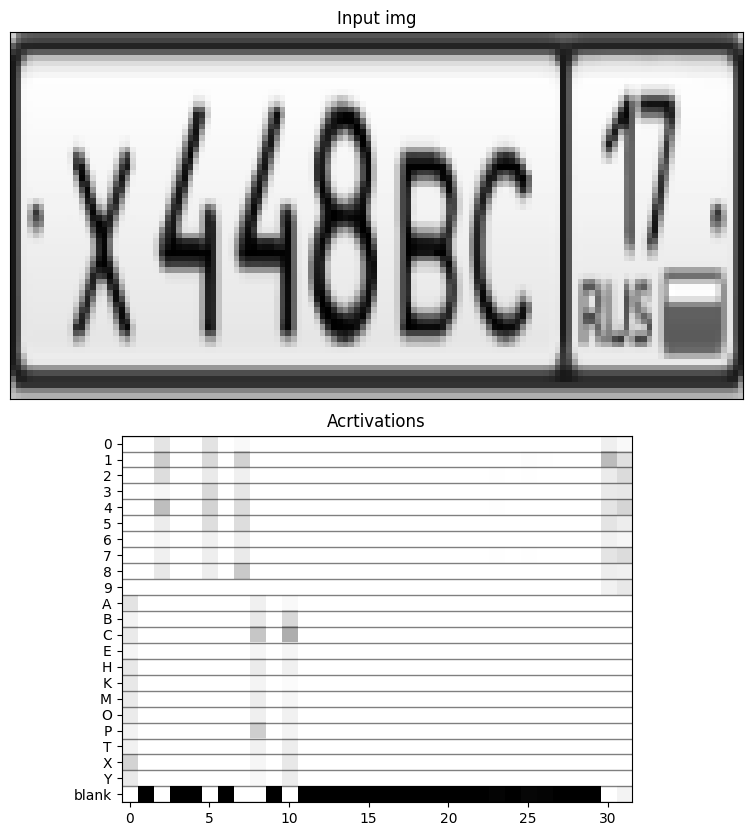

Predicted: H461PX14
Expected: H465HE18


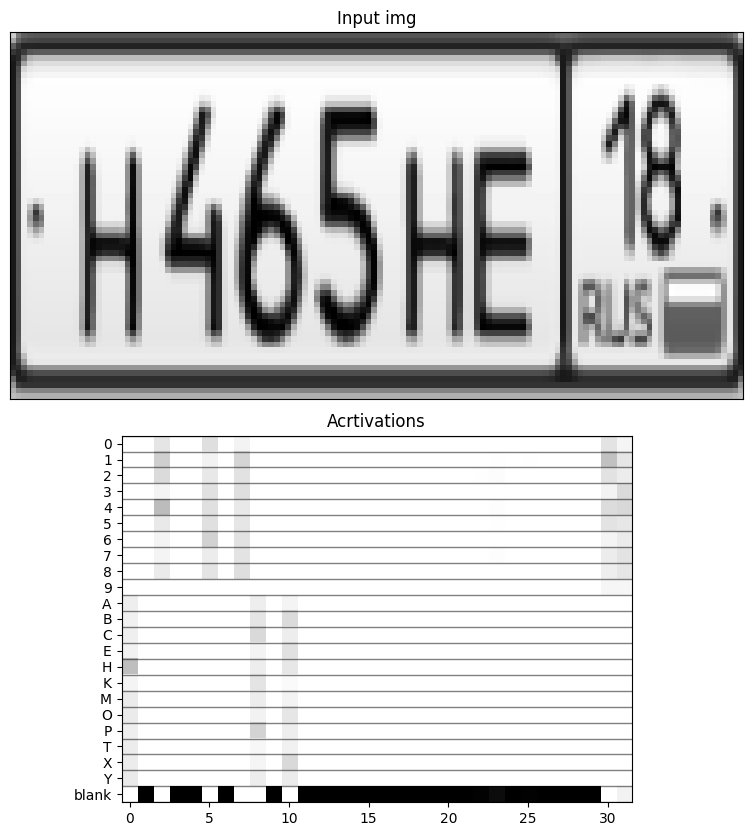

Predicted: Y838PT27
Expected: Y853XT81


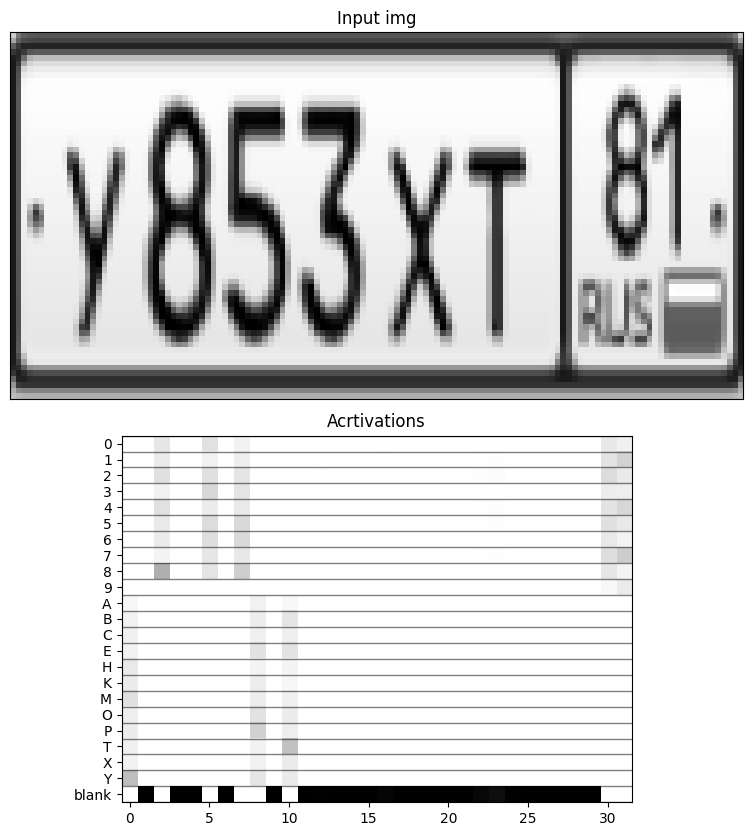

Predicted: X856PT19
Expected: X082PT69


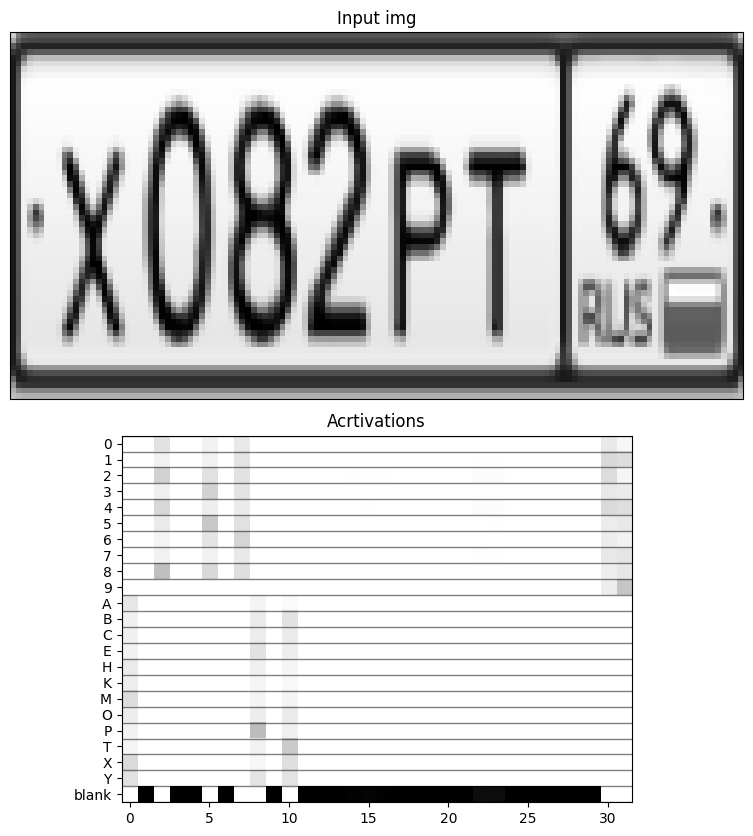

In [133]:
#Визуализация результата

import matplotlib.gridspec as gridspec

TEST_BATCH_SIZE = 4 # меняя батч можно улучшить работу NN

test_data = DataGenerator(TEST_DATA_PATH,
                          img_width=IMG_WIDTH,
                          img_height=IMG_HEIGHT,
                          batch_size=TEST_BATCH_SIZE,
                          letters=LETTERS,
                          max_label_len=PLATE_NUM_LENGTH)

for batch_img, y_true in test_data():
    y_pred = model.predict(batch_img)
    labels_pred = model.decode(y_pred, LETTERS)
    labels = [indices_to_text(i, LETTERS) for i in y_true['labels']]

    for i in range(TEST_BATCH_SIZE):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nExpected: %s' % (labels_pred[i], labels[i]))
        ax1.set_title('Input img')
        ax1.imshow(np.squeeze(batch_img[i]), cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(y_pred[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(LETTERS) + 1)))
        ax2.set_yticklabels(LETTERS + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(LETTERS) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)

        plt.show()
    break